In [1]:
import os,sys,math
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import importlib
import matplotlib.pyplot as plt
import random
sys.path.append('../hw3') ##直接使用hw3中的model
import image_classification
import image_set
importlib.reload(image_set)
importlib.reload(image_classification)
random.seed(10)


current_dir = os.path.abspath('.')
MODEL_PATH =  os.path.join(current_dir, "../hw3/<class 'image_classification.GYHF_LetNet5'>.pkl")
TRAIN_DIR = os.path.join(current_dir, "../hw3/data/training")
OUTPUT_DIR = os.path.join(current_dir, "output")
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


In [2]:
#指定模型类别
model_class = image_classification.GYHF_LetNet5
data = image_set.LearningSet( TRAIN_DIR, model_class.input_size, False)
#使用已经训练好的hw3中的model
model = torch.load(MODEL_PATH)

In [ ]:
#选出每个类别概率最高的图片
import saliency_map

##先选出概率最高的图片的索引数字
data_loader = torch.utils.data.DataLoader(
    data, 1024, shuffle=False,
    num_workers=2)
class_num = data.GetClassNum()
#先计算出所有图片的输出
output = np.zeros((1, class_num)) #空矩阵，便于使用concatenate
model.eval()  # 会关闭dropout、batchnorm等
with torch.no_grad():  # 不构建计算图
    for _, info in enumerate(data_loader):
        images, labels = info             
        y_pred = model(images).numpy()                
        output = np.concatenate((output, y_pred), axis=0)            
output = torch.tensor(output[1:]).float() #去掉第一行的空行
idx = []
for i in range(class_num):
    idx.append(output[:,i].topk(1)[1].item()) #得到所需图片的索引，即为每一类别中概率最大的图片索引号
images,labels = data.GetBatch(idx) #取出这些图片


In [ ]:
##画出每个类别概率最高的图片的salient map
saliency_map.draw(model, images, labels, 8)

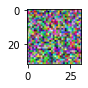

In [3]:
import filter_visualization

image = filter_visualization.generate_image(model, model.features[6], 1, (3,model.input_size[0], model.input_size[1]),iters=1000, lr=0.01)
plt.figure( figsize=(1,1))
plt.imshow(image)